<a href="https://colab.research.google.com/github/AmeerAliSaleem/isoc_tech_workshop_2024/blob/main/Warwick_ISoc_Tech_Project_Ghost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warwick ISoc Tech Workshop 16/11/24: Project Ghost
---
* Overview of the task: we will build some NLP models to predict the sentiment of input texts, choosing from either positive, neutral or negative sentiment.
* For this mini-project, we will be using the following Kaggle dataset of tweet data: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/
* Performance metric of choice: accuracy (proportion of correctly classified tweets). There are plenty of other metrics to choose from (such as precision, recall, f1 score, etc.), the uses of which depend on the context of your data science problem.
* Google Colab: a cloud-based platform where notebooks can be developed and executed with ease. Really useful for data science beginners; there is no need to install packages directly onto your local machine, since all of our code is running in the cloud. However, the file directory will be wiped after each use, meaning files need to be re-downloaded for every fresh colab instance. This isn't really an issue for us though :)

The following notebook entails one potential approach to the NLP task. This is by no means the best solution. In fact, this is just a starting point. Run the code, try to understand what it all means and tweak it as much as you want/need. The more you play around with this sample, the better you will come to understand it. (And don't worry if you mess up anything beyond repair, just download the original notebook and try again.)

## Imports
---

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import random
import regex as re
import nltk
import joblib
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

I have downloaded the datasets into a GitHub repo for ease of access. If you endeavour to work with other Kaggle datasets in the future, you should look into Kaggle's public API, which will make it easier for you to load in datasets for future projects.

In [2]:
train = pd.read_csv("https://github.com/AmeerAliSaleem/isoc_tech_workshop_2024/raw/refs/heads/main/train.csv", encoding='unicode_escape')
test = pd.read_csv("https://github.com/AmeerAliSaleem/isoc_tech_workshop_2024/raw/refs/heads/main/test.csv", encoding='unicode_escape')

In [3]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Data Preprocessing
---
In this section, we will carry out a bunch of data preprocessing steps, so that our ML models understand the format of the data. A lot of it will revolve around converting text data into a suitable numerical format.

In [4]:
# hone in on the columns of data we actually care about
df = train[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
# investigate class balance (or lack thereof)
df['sentiment'].value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


In [6]:
sentiment_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

df['sentiment'] = df['sentiment'].map(sentiment_mapping)
df

<ipython-input-6-ca2ef02b3bab>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map(sentiment_mapping)


,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27476,wish we could come see u on Denver husband l...,0
27477,I`ve wondered about rake to. The client has ...,0
27478,Yay good for both of you. Enjoy the break - y...,2
27479,But it was worth it ****.,2


Computers understand numbers, not words. As such, we require some method of converting each sentence into a numerical format. To achieve this, we aim to convert each sentence into a vector that can be passed onto our resultant models. We could naively make a new vector for each sentence, but this would be pointless without some encoding of the words included in each sentence. That is, we need to preserve the meaning of the sentences in some way during this vectorisation process.

There exist pre-trained neural network models which take English words and convert them into high-dimensional vectors. In the literature, these are referred to as *word embeddings*. This will enable us to achieve the desired numerical format. Crucially though, these networks are trained to ensure that words of similar meanings are clustered together in these vector spaces. There are plenty of choices of model (in fact you can actually construct your own from the data!), but here we will be leveraging the Gensim Word2Vec corpus: https://radimrehurek.com/gensim/index.html

In [7]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

import spacy
import string

import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [8]:
wv = api.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [9]:
print(wv)

KeyedVectors<vector_size=50, 1193514 keys>


In [10]:
# some helper functions for later

def sent_vec(sent):
    """
    Function for converting tokenised sentences into a vector
    by taking the mean of the vectors for each word in the sentence.
    """
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)

    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res




Before any embedding procedures, there are a few data cleaning steps to take care of:
* Removal of stopwords: getting rid of words like 'the', 'and', etc. will help the model focus on the words in each text that contribute meaningfully to the text's sentiment. There are various online packages with their own list of stopwords. In the below code block, we choose SpaCy's stopword list.
* Lemmatisation/stemming: words like 'jump', 'jumping' and 'jumped' are all technically different words but they essentially have the same meaning. We want our models to recognise them as effectively all the same word 'jump'. This will help to reduce the computational complexity of our input space (try reading up on the so-called 'curse of dimensionality' online).
* Tokenisation: the process of converting the remaining words into bite-size chunks ('tokens') will prime the Series of text data to be embedded into high dimensional space.

In [11]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

punctuations = string.punctuation

Note: the following code block will take a while to run as the tokeniser is applied to each row of data.

In [12]:
def spacy_tokenizer(sentence):
    """
    Function for converting each sentence of words into a list of word tokens.
    Before this, stop words are removed and a brief lemmatisation procedure is also applied.
    """
    doc = nlp(sentence)

    # Lemmatisation and conversion to lower case
    mytokens = [word.lemma_.lower().strip() for word in doc ]

    # Removal of stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

df['text'] = df['text'].apply(str)

df['tokens'] = df['text'].apply(spacy_tokenizer)
df.head()

<ipython-input-12-f6a8e7341699>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(str)
<ipython-input-12-f6a8e7341699>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['text'].apply(spacy_tokenizer)


,text,sentiment,tokens
0,"I`d have responded, if I were going",1,"[i`d, respond]"
1,Sooo SAD I will miss you here in San Diego!!!,0,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,0,"[boss, bully, ...]"
3,what interview! leave me alone,0,"[interview, leave]"
4,"Sons of ****, why couldn`t they put them on t...",0,"[son, couldn`t, release, buy]"


Now for the sentence vector embeddings. There are many ways to achieve this. For each sentence, we will conduct the following: each token in the sentence will be converted into a high dimensional vector with Word2Vec. This will give us a list of vectors, from which we compute the average vector, and take that to be the vector of the overall sentence.

This code block will take a while to run; the tokeniser is being applied to every row of text.

In [13]:
df['vectors'] = df['tokens'].apply(sent_vec)
df.head()

<ipython-input-13-ae9aff5a3f20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vectors'] = df['tokens'].apply(sent_vec)


,text,sentiment,tokens,vectors
0,"I`d have responded, if I were going",1,"[i`d, respond]","[0.5846999883651733, 0.49103501439094543, -0.4..."
1,Sooo SAD I will miss you here in San Diego!!!,0,"[sooo, sad, miss, san, diego]","[0.16032333175341287, 0.428380835801363, 0.356..."
2,my boss is bullying me...,0,"[boss, bully, ...]","[0.3568333288033803, 0.5311500132083893, -0.13..."
3,what interview! leave me alone,0,"[interview, leave]","[0.1312536665548881, 0.4501099983851115, 0.213..."
4,"Sons of ****, why couldn`t they put them on t...",0,"[son, couldn`t, release, buy]","[-0.3156049996614456, 0.25286317575955763, -0...."


In [14]:
len(df['vectors'].iloc[0])

50

Note: this is one of many different ways in which word embeddings can be created. Do some research and try other methods to evaluate which method will suit your use case the best.

In any case, we can now package up the training and testing sets:

In [15]:
X = df['vectors'].to_list()
y = df['sentiment'].to_list()

Now we have our word embeddings saved in `X`, and the corresponding sentiment labels saved in `y`. For the sake of training our models, we need to split the data into a training set and a testing set.

**? What does the `stratify` argument do in the below line of code ?**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

**? The `SettingWithCopyWarning` message is thrown up in some of the preprocessing steps above. Can you fix them ?**

At long last, we're now ready for some modelling!

## Model 1: Random Forest
The random forest algorithm trains a collection of decision trees on the training data, then aggregates their classifications in a majority-vote fashion to produce its predictions. Standalone decision trees are prone to overfitting, and so this bagging ensemble technique aims to mitigate that from happening while maintaining model performance, albeit at the cost of more training time. I would recommend checking out the scikit-learn documentation for more information: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_test, y_pred)

print(f"Accuracy achieved by random forest is {acc1}.")

Accuracy achieved by random forest is 0.6165181007822449.


We can plot a confusion matrix to analyse the distribution of predictions:

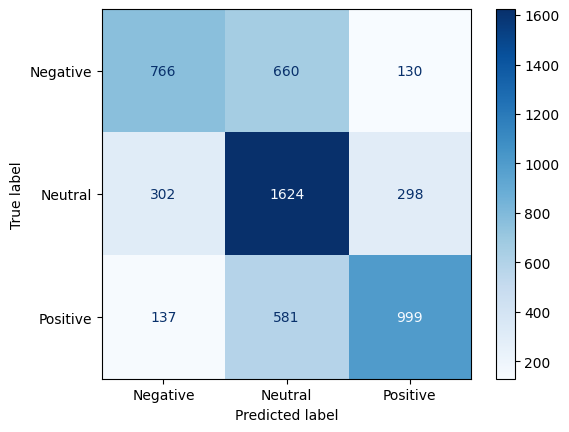

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

We can save this model so that it doesn't have to be trained from scratch all over again:

In [ ]:
joblib.dump(model1, 'random_forest_model.joblib')

['random_forest_model.joblib']

**? What do you think of the results, and how do you think we could improve them ?**

Assuming that we've done all we can for now, the final step would be to conduct some hyperparameter tuning.

### Hyperparameter Tuning
The random forest has its own set of arguments called hyperparameters. In order to fine-tune such a model, we can search through various combinations of hyperparameters to see which boasts the best performance on the test data.

There are a few ways in which this can be done, but since I'm feeling slightly lazy at this point in typing up this notebook, we ~cut and paste~ follow the guidance of https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

The hyperparameter code took so long to run that I've just commented it out for now. If you want to try it, either set aside an hour or run the code on your local machine (or tweak the hyperparameter grid). In any case, tuning will improve performance by at most a few percentage points, so consider the trade-off between training time and performance.

In particular, we employ a grid search with 3-fold cross validation:

**? What other hyperparameter tuning techniques are there ?**

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Create the parameter grid based on the results of random search
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300]
# }
# # Create a based model
# rf_random = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf_random, param_grid = param_grid,
#                           cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# # output best performing set of hyperparameters
# grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
# y_pred_grid_search = grid_search.predict(X_test)
# acc_grid_search = accuracy_score(y_test, y_pred_grid_search)
# cm_grid_search = confusion_matrix(y_test, y_pred_grid_search)

# print(f"Accuracy achieved by random forest is {acc_grid_search}.")
# print("Confusion matrix:")
# print(cm_grid_search)

Accuracy achieved by random forest is 0.6219756230671275.
Confusion matrix:
[[ 719  722  115]
 [ 246 1692  286]
 [  99  610 1008]]


In [ ]:
# joblib.dump(grid_search, 'random_forest_tuned.joblib')

['random_forest_tuned.joblib']

In [ ]:
# could also dump the models as pickle files
import pickle

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model1, file)

# with open('random_forest_tuned.pkl', 'wb') as file:
#     pickle.dump(grid_search, file)

## Model 2: Gradient Boosting

The next model we will try is the Gradient Boosting Classifier: https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Unlike the random forest, the this model is an example of a boosting algorithm.

**? What are the hyperparameters for GBC ?**


**? What is the difference between bagging and boosting algorithms ?**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
cm_gb = confusion_matrix(y_test, y_pred_gb)

print(f"Accuracy achieved by Gradient Boosted Classifier is {acc_gb}.")

Accuracy achieved by Multinomial Bayes Classifier is 0.6341640895033654.


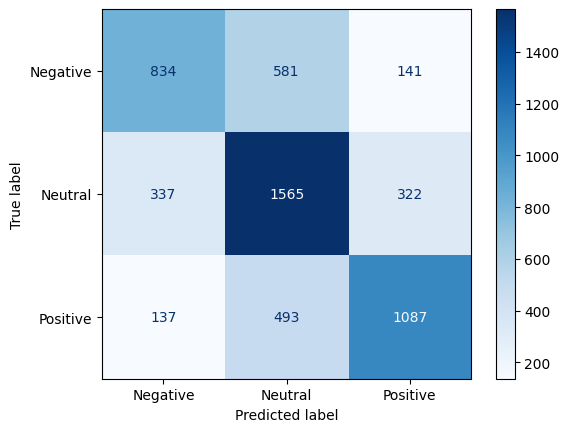

In [ ]:
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=['Negative','Neutral','Positive'])
disp_gb.plot(cmap=plt.cm.Blues)
plt.show()

**? Have you noticed how much code we simply copied over from the Model 1 section ?**

**? What other classification algorithms could we try ?**

## Model 3: Fine-tuning a Pre-trained Model

**For Model 3, we will not be using the Data Preprocessing section, so you won't have to run that bit.**

One thing I really like about the field of data science is that the landscape is constantly growing and evolving. This means that, as a data scientist, there are always more frameworks to learn about and explore.

One such avenue is the process of taking a pre-trained NLP model and comparing it directly to our custom models. For example, Hugging Face (https://huggingface.co/) provides an abundance of pre-trained NLP models that are freely available for us to leverage.

Requirements for this section:
* HuggingFace account
* HuggingFace access token
* wandb API key

In [17]:
!pip install -q transformers

In [18]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [19]:
tweet_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


We can apply the pre-trained model directly to the tweets and see how it performs:

In [22]:
df_sample = df.head(10)
pre_trained_output = df_sample['text'].apply(lambda x: tweet_model(x))
df_sample['pre_trained_model'] = pre_trained_output
df_sample

<ipython-input-22-4325712e55ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['pre_trained_model'] = pre_trained_output


,text,sentiment,tokens,vectors,pre_trained_model
0,"I`d have responded, if I were going",1,"[i`d, respond]","[0.5846999883651733, 0.49103501439094543, -0.4...","[{'label': 'NEU', 'score': 0.964800238609314}]"
1,Sooo SAD I will miss you here in San Diego!!!,0,"[sooo, sad, miss, san, diego]","[0.16032333175341287, 0.428380835801363, 0.356...","[{'label': 'NEG', 'score': 0.8694149851799011}]"
2,my boss is bullying me...,0,"[boss, bully, ...]","[0.3568333288033803, 0.5311500132083893, -0.13...","[{'label': 'NEG', 'score': 0.9699698686599731}]"
3,what interview! leave me alone,0,"[interview, leave]","[0.1312536665548881, 0.4501099983851115, 0.213...","[{'label': 'NEG', 'score': 0.9334067106246948}]"
4,"Sons of ****, why couldn`t they put them on t...",0,"[son, couldn`t, release, buy]","[-0.3156049996614456, 0.25286317575955763, -0....","[{'label': 'NEG', 'score': 0.8686566948890686}]"
5,http://www.dothebouncy.com/smf - some shameles...,1,"[http://www.dothebouncy.com/smf, shameless, pl...","[0.21432856576783316, 0.10531485825777054, -0....","[{'label': 'POS', 'score': 0.9159455895423889}]"
6,2am feedings for the baby are fun when he is a...,2,"[2, feeding, baby, fun, smile, coo]","[-0.1994233379761378, 0.18277082778513432, -0....","[{'label': 'POS', 'score': 0.9897408485412598}]"
7,Soooo high,1,"[soooo, high]","[-0.07654666900634766, -0.05108332633972168, 0...","[{'label': 'NEU', 'score': 0.6377530097961426}]"
8,Both of you,1,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[{'label': 'NEG', 'score': 0.6547879576683044}]"
9,Journey!? Wow... u just became cooler. hehe....,2,"[journey, wow, ..., u, cool, hehe, ..., possible]","[0.22059771844318934, 0.21876586388264382, -0....","[{'label': 'POS', 'score': 0.984774649143219}]"


In [23]:
hugging_face_dict = {'NEG' : 0, 'NEU' : 1, 'POS' : 2}

In [24]:
def hugging_face_predictor(text_series):
  hugging_face_series = text_series.apply(lambda x: tweet_model(x))
  predictions = hugging_face_series.apply(lambda x: hugging_face_dict[x[0]['label']])

  return predictions

In [152]:
df_reduced = df.head(200)
df_reduced['hugging_face_predictions'] = hugging_face_predictor(df_reduced['text'])
df_reduced.head()

<ipython-input-152-5542c4945178>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['hugging_face_predictions'] = hugging_face_predictor(df_reduced['text'])


,text,sentiment,tokens,vectors,hugging_face_predictions
0,"I`d have responded, if I were going",1,"[i`d, respond]","[0.5846999883651733, 0.49103501439094543, -0.4...",1
1,Sooo SAD I will miss you here in San Diego!!!,0,"[sooo, sad, miss, san, diego]","[0.16032333175341287, 0.428380835801363, 0.356...",0
2,my boss is bullying me...,0,"[boss, bully, ...]","[0.3568333288033803, 0.5311500132083893, -0.13...",0
3,what interview! leave me alone,0,"[interview, leave]","[0.1312536665548881, 0.4501099983851115, 0.213...",0
4,"Sons of ****, why couldn`t they put them on t...",0,"[son, couldn`t, release, buy]","[-0.3156049996614456, 0.25286317575955763, -0....",0


In [153]:
hugging_face_accuracy = accuracy_score(df_reduced['sentiment'].values,
                                       df_reduced['hugging_face_predictions'].values)

print(f"Accuracy achieved by pre-trained (non fine-tuned) Hugging Face transformer on sample of data is {hugging_face_accuracy}.")

Accuracy achieved by pre-trained (non fine-tuned) Hugging Face transformer is 0.725.


The above value is the accuracy when using the transformer out of the box. It seems to perform well, but what happens if we fine-tune the model on our tweet data?

In [27]:
import torch
torch.cuda.is_available()

False

In [28]:
df_train = train[['text', 'sentiment']]
df_test = test[['text', 'sentiment']]

sentiment_mapping = {
    "negative" : 0,
    "neutral" : 1,
    "positive" : 2
}

df_train['sentiment'] = df_train['sentiment'].map(sentiment_mapping)
df_test['sentiment'] = df_test['sentiment'].map(sentiment_mapping)

df_train.head()

<ipython-input-28-d32371ce76fd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sentiment'] = df_train['sentiment'].map(sentiment_mapping)
<ipython-input-28-d32371ce76fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sentiment'] = df_test['sentiment'].map(sentiment_mapping)


,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


It will take too long for the model to train on the entire dataset, so for the rest of this section we will restrict ourselves to a sample of the tweets. But if you happen to have a few GPUs lying around, feel free to run the rest on your local machine for larger training samples and more training iterations.

In [162]:
small_train_dataset = df_train.dropna().sample(n=2000, random_state=8)
small_test_dataset = df_test.dropna().sample(n=200, random_state=8)

small_train_dataset['text'] = small_train_dataset['text'].astype(str)
small_test_dataset['text'] = small_test_dataset['text'].astype(str)

small_train_dataset.head()

,text,sentiment
11977,it is so sad that me and my roommate fry chic...,0
12306,are you TINK`N the people on the street in NY...,1
1371,The episode was AMAZING...I cried when I saw ...,2
21825,"Ugh, migraine.",0
6043,thanks homskis! Its like christmas!,2


In [74]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [155]:
def preprocess_function(examples):
   return tokenizer(examples, truncation=True)

tokenized_train = small_train_dataset['text'].apply(lambda x: preprocess_function(x))
tokenized_test = small_test_dataset['text'].apply(lambda x: preprocess_function(x))

In [156]:
for i in range(len(tokenized_train)):
  tokenized_train.iloc[i]['labels'] = int(small_train_dataset['sentiment'].iloc[i])

for i in range(len(tokenized_test)):
  tokenized_test.iloc[i]['labels'] = int(small_test_dataset['sentiment'].iloc[i])

In [157]:
tokenized_train.iloc[0]

{'input_ids': [101, 2009, 2003, 2061, 6517, 2008, 2033, 1998, 2026, 18328, 14744, 7975, 2074, 2055, 2296, 2305, 1030, 14210, 1018, 1012, 2057, 2074, 2736, 3892, 1036, 1055, 14108, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 0}

In [113]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [114]:
from transformers import AutoModelForSequenceClassification
distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


If the below code block throws any errors, rerun it and they will (hopefully) disappear:

In [147]:
!pip install evaluate
import evaluate

def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = accuracy_score(labels, predictions)
   return {"accuracy": accuracy}

In [116]:
from huggingface_hub import notebook_login
notebook_login()

In [163]:
from transformers import TrainingArguments, Trainer

repo_name = "AmeerSaleem/test_model"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=4,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=distilbert,
   args=training_args,
   train_dataset=list(tokenized_train),
   eval_dataset=list(tokenized_test),
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


<ipython-input-163-12c051b955b5>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [164]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=252, training_loss=0.34631601969401044, metrics={'train_runtime': 1245.5452, 'train_samples_per_second': 3.211, 'train_steps_per_second': 0.202, 'total_flos': 40976622796752.0, 'train_loss': 0.34631601969401044, 'epoch': 4.0})

In [165]:
trainer.evaluate()

{'eval_loss': 0.8085094690322876,
 'eval_accuracy': 0.69,
 'eval_runtime': 6.9479,
 'eval_samples_per_second': 14.393,
 'eval_steps_per_second': 1.007,
 'epoch': 4.0}

We have not conducted much training here. To improve model performance, you can try increasing the training data size and the number of epochs (training iterations).

You can download the model's files at https://huggingface.co/AmeerSaleem/test_model/tree/main

## Extension: Custom Neural Network

Finally, you could build your own neural network from scratch and train it for sentiment analysis on our input data. I won't be providing the code for this one, but you should check out one of TensorFlow or PyTorch to understand how to conduct Deep Learning NLP from first principles.

For TensorFlow beginners, check out this playlist: https://youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&si=679AZVRz6NEemrvv

## Conclusion & Next Steps
---
Hope you enjoyed going through this notebook! Here are some things to think about:
1. In data science, there is no one-size-fits-all approach. Try a few different methods and see which produces the best results for you.
2. Garbage in, garbage out: data cleaning is a biiggggg part of the job. No matter how good your model, it cannot yield decent performance in the presence of low-quality data.
3. Try to enjoy the process. Stuff will break, weird errors will be thrown, and you may be left bashing your head against a wall at times. Patience will take you a lot further in your data career than anything else.
4. Ask for help when you get stuck :) I am not going to tell you to rely on ChatGPT, but I am also not _not_ going to tell you to rely on ChatGPT.

Our work here is far from finished! Once you've got a model with satisfactory performance, save it and work with the Ghost Data Engineering team to get your predictor into production. You could use the model on comments left on blog posts to inform blog writers about how their content is being received. Don't stop there: could this feedback be built into an analytics dashboard? Could the data engineers support you in storing any relevant analytics and model training resources?


Don't forget to consult the ISoc Tech Notion page: https://silky-double-2ea.notion.site/Tech-Workshop-Resources-12f169d2bb7f80d19d11ea06067015d4?pvs=74